# Center Laneline Detection - Autonomous Driving

## Abstract

In this notebook, we perform Center Laneline Detection by fine tuning pre-trained SOTA deep learning models such as ResNet backbone CNN model and Vision Transformer Model on the OpenLaneV2 dataset. Identifying the lanelines is essential for many downstream tasks like Motion Planning, 3D Occupancy Detection etc. in Autonomous Driving. 

## Dataset Description

The OpenLane dataset consists of multi-view images taken by cameras mounted on an ego vehicle. The dataset provides annotations for Lane lines, Traffic elements, Area elements(Pedestrian Crossing, Sidewalk etc)

Dataset Link - [here](https://github.com/OpenDriveLab/OpenLane-V2/blob/master/data/README.md#download)

In [1]:
!pip install torch torchvision transformers 


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import os
import sys
import cv2
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor


### Utility Functions

#### Project 3d world co-ordinates to 2d image co-ordinates

In [3]:
import numpy as np

THICKNESS = 4

COLOR_DEFAULT = (0, 0, 255)
COLOR_DICT = {
    0:  COLOR_DEFAULT,
    1:  (255, 0, 0),
    2:  (0, 255, 0),
    3:  (255, 255, 0),
    4:  (255, 0, 255),
    5:  (0, 128, 128),
    6:  (0, 128, 0),
    7:  (128, 0, 0),
    8:  (128, 0, 128),
    9:  (128, 128, 0),
    10: (0, 0, 128),
    11: (64, 64, 64),
    12: (192, 192, 192),
}


def interp_arc(points, t=1000):
    r'''
    Linearly interpolate equally-spaced points along a polyline, either in 2d or 3d.

    Parameters
    ----------
    points : List
        List of shape (N,2) or (N,3), representing 2d or 3d-coordinates.
    t : array_like
        Number of points that will be uniformly interpolated and returned.

    Returns
    -------
    array_like  
        Numpy array of shape (N,2) or (N,3)

    Notes
    -----
    Adapted from https://github.com/johnwlambert/argoverse2-api/blob/main/src/av2/geometry/interpolate.py#L120

    '''
    
    # filter consecutive points with same coordinate
    temp = []
    for point in points:
        point = point.tolist()
        if temp == [] or point != temp[-1]:
            temp.append(point)
    if len(temp) <= 1:
        return None
    points = np.array(temp, dtype=points.dtype)

    assert points.ndim == 2

    # the number of points on the curve itself
    n, _ = points.shape

    # equally spaced in arclength -- the number of points that will be uniformly interpolated
    eq_spaced_points = np.linspace(0, 1, t)

    # Compute the chordal arclength of each segment.
    # Compute differences between each x coord, to get the dx's
    # Do the same to get dy's. Then the hypotenuse length is computed as a norm.
    chordlen = np.linalg.norm(np.diff(points, axis=0), axis=1)  # type: ignore
    # Normalize the arclengths to a unit total
    chordlen = chordlen / np.sum(chordlen)
    # cumulative arclength

    cumarc = np.zeros(len(chordlen) + 1)
    cumarc[1:] = np.cumsum(chordlen)

    # which interval did each point fall in, in terms of eq_spaced_points? (bin index)
    tbins = np.digitize(eq_spaced_points, bins=cumarc).astype(int)  # type: ignore

    # #catch any problems at the ends
    tbins[np.where((tbins <= 0) | (eq_spaced_points <= 0))] = 1  # type: ignore
    tbins[np.where((tbins >= n) | (eq_spaced_points >= 1))] = n - 1

    s = np.divide((eq_spaced_points - cumarc[tbins - 1]), chordlen[tbins - 1])
    anchors = points[tbins - 1, :]
    # broadcast to scale each row of `points` by a different row of s
    offsets = (points[tbins, :] - points[tbins - 1, :]) * s.reshape(-1, 1)
    points_interp = anchors + offsets
#     print(f"points interp : {points_interp}")
    return points_interp



In [4]:
# Project world co-ordindates to image co-ordinates

def _project(points, intrinsic, extrinsic):
    if points is None:
        return points
    
    points_in_cam_cor = np.linalg.pinv(np.array(extrinsic['rotation'])) \
        @ (points.T - np.array(extrinsic['translation']).reshape(3, -1))
    
#     print("points cam 1 : ", points_in_cam_cor)
    
    points_in_cam_cor = points_in_cam_cor[:, points_in_cam_cor[2, :] > 0]
#     print("points cam : ", points_in_cam_cor)
    
    if points_in_cam_cor.shape[1] > 1:
        points_on_image_cor = np.array(intrinsic['K']) @ points_in_cam_cor
        points_on_image_cor = points_on_image_cor / (points_on_image_cor[-1, :].reshape(1, -1))
        points_on_image_cor = points_on_image_cor[:2, :].T
    else:
        points_on_image_cor = None
#     print(" points_on_image_cor : ", points_on_image_cor)
    return points_on_image_cor

### Defining Custom Dataset Class

In this class, we define functions to perform pre-processing and setup the data for the model inference

In [5]:
class Lane3DDataset(Dataset):
    def __init__(self, image_dir, data_dict, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.load_annotations(data_dict)

    def load_annotations(self, data_dict):
        annotations = []
        max_size = 0
        try:
            for ann in data_dict:
                frame = data_dict[ann]['sensor']['ring_front_center']# get centerline annotations
                image_name = frame['image_path'].split("/")[-1]
                # camera properties
                intrinsics = frame['intrinsic']
                extrinsics = frame['extrinsic']
                lane_segment = data_dict[ann]['annotation']['lane_segment']
                centr_line = []
                
                # identify lane lines belonging to respective images
                for lane in lane_segment:
                    lane_id = lane['id']
                    lane_points_3d = lane['centerline']
                    lane_points_2d = _project(interp_arc(np.array(lane_points_3d)), frame['intrinsic'],frame['extrinsic'])
                
                    if type(lane_points_2d) == np.ndarray:
                            
                        centr_line.append(lane_points_3d)
                        
                # create a list of image and annotations for training     
                annotations.append((image_name, intrinsics, extrinsics, centr_line))
                
                if max_size < len(centr_line):
                    max_size = len(centr_line)
                # print(f"len of annotations : {len(annotations)}")
                # print("max size : ", max_size)
            return annotations
        except:
            print(data_dict[ann].keys())
            
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name, intrinsics, extrinsics, lane_points_2d = self.annotations[idx]
        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        lane_points_2d = torch.tensor(lane_points_2d, dtype=torch.float32)

        return image, intrinsics, extrinsics, lane_points_2d


In [6]:
# Function to pad lane lines for consistency.
# The data loader expects each lane line annotation to have the same dimensions.


def collate_fn(batch):
    images = []
    intrinsic = []
    extrinsic = []
    lane_points = []
    
    for item in batch:
        if len(item[3]) > 0:
            images.append(item[0])
            intrinsic.append(item[1])
            extrinsic.append(item[2])
            lane_points.append(item[3])
    
    # print(f"Lane points : {lane_points}")
    images = torch.stack(images)
    if len(lane_points) > 0:
        # Pad lane points
        max_num_lanes = max(len(lanes) for lanes in lane_points)
        max_num_points = max(max(len(lane) for lane in lanes) for lanes in lane_points if len(lanes) > 0)

        padded_lane_points = []
        for lanes in lane_points:
            padded_lanes = []
            for lane in lanes:
                lane = torch.tensor(lane, dtype=torch.float)
                # print(f"lane shape: {lane}")
                if lane.shape[0] < max_num_points:
                    padding = torch.zeros((max_num_points - lane.shape[0], 3))
                    lane = torch.cat((lane, padding), dim=0)
                padded_lanes.append(lane)
            if len(padded_lanes) < max_num_lanes:
                for _ in range(max_num_lanes - len(padded_lanes)):
                    padded_lanes.append(torch.zeros((max_num_points, 3)))
            padded_lane_points.append(torch.stack(padded_lanes))
        # print(len(padded_lane_points))
        padded_lane_points = torch.stack(padded_lane_points)

        return images, intrinsic, extrinsic, padded_lane_points
    else:
        return [], [], [], []


In [7]:
# Function to compute the difference between predicted and ground truth laneline points

def compute_offset(preds, gts):
    offset_list = []
    
    for i in range(len(preds)):
        offset_list.append(preds[i] - gts[i][3])
    return offset_list
        
# element_wise_off = compute_offset(predicted_points_2d_list, val_dataset.annotations)

In [8]:
# Flatten prediction list
def flatten_points(predicted_points_3d_list):
    points_3d = []

    for pts in predicted_points_3d_list:
        for t in pts:
            points_3d.append(t)
            
    return points_3d

In [9]:
# Project 3D points to 2d image plane
def project_3D_2D(gt_points, points_3d, intrinsic, extrinsic):
    # project 3d to 2d - ground truth
    pts_2d_gt = []
    for pt in gt_points:
        pts_ = _project(interp_arc(pt), intrinsic, extrinsic)
        if pts_ is not None:
            pts_2d_gt.append(pts_)

    # project 3d to 2d - predictions

    pts_2d_preds = []
    for pt in range(points_3d[0].shape[0]):
        pts_ = _project(interp_arc(np.array(points_3d[0][pt])), intrinsic, extrinsic)
        if pts_ is not None:
            pts_2d_preds.append(pts_)
            
    return pts_2d_gt, pts_2d_preds

In [10]:
# Function to draw lines on the image
def _draw_lane_centerline(image, points_list):
    
    colors = [COLOR_DEFAULT]
    # print(colors)
    for idx, color in enumerate(colors):
        for points in points_list:
            for i in range(len(points) - 1):
                x1 = int(points[i][0] + idx * THICKNESS * 1.5)
                y1 = int(points[i][1] + idx * THICKNESS * 1.5)
                x2 = int(points[i+1][0] + idx * THICKNESS * 1.5)
                y2 = int(points[i+1][1] + idx * THICKNESS * 1.5)

                cv2.line(image, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=THICKNESS, lineType=cv2.LINE_AA)
                
    return image


In [11]:
def visualization(img_file, gt_list, preds_list):
    img_path = f"./{img_file}"
    # print(img_path)
    img_arr = cv2.imread(img_path)
    
    gt_img = _draw_lane_centerline(img_arr, gt_list)
    
    plt.figure(figsize=(8,6))
    
    plt.subplot(1, 2, 1)
    plt.title('Ground truth vs Predictions')
    plt.imshow(gt_img)
    
    img_arr = cv2.imread(img_path)
    pred_img = _draw_lane_centerline(img_arr, preds_list)

    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)
    
    plt.show()
    

## Model Inference

In [12]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Function to get predictions on test images
def get_predictions(model, weights):

    model.load_state_dict(torch.load(weights, map_location=torch.device('cpu')))
    model = model.to(device)  

    # setup model for evaluation
    model.eval()

    # data for projecting 3d points to 2d for visualization
    predicted_points_3d_list = []
    intrinsic_list = []
    extrinsic_list = []

    with torch.no_grad():
        for images, intrinsic, extrinsic, lane_lines in val_dataloader:
            images = images.to(device)

            # get predictions
            outputs = model(images)
            # print(outputs)

            predicted_points_3d_list.append(outputs.to(device))
            intrinsic_list.append(intrinsic)
            extrinsic_list.append(extrinsic)
            
    return predicted_points_3d_list, intrinsic_list, extrinsic_list


        

### Setup data

In [14]:
data_dict = pd.read_pickle('data_dict.pkl')

In [15]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#### Data Loader for model

In [16]:
val_dataset = Lane3DDataset(image_dir='./images/', data_dict=data_dict, transform=transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

### Laneline Detection using ResNet

#### RESNET 50 base model with Output Layer Modification

In [17]:
# Base resnet model with output layer modification
class ResNet3DLaneDetection(nn.Module):
    def __init__(self, num_points, max_num_lane_lines):
        super(ResNet3DLaneDetection, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Remove the fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Add a fully connected layer to predict 3D laneline points
        self.fc = nn.Linear(2048, max_num_lane_lines * num_points * 3)  

    def forward(self, x):
        x = self.resnet(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x.view(x.size(0), max_num_lane_lines, num_points,3) 

# Number of points to detect per lane
# num_points = 10
# model = ResNet3DLaneDetection(num_points=num_points)


In [18]:
# Load model for evaluation
num_points = 10
max_num_lane_lines = 61

model = ResNet3DLaneDetection(num_points=num_points, max_num_lane_lines=max_num_lane_lines)

weights = "./models/lane_detection_model.pth"

predicted_points_3d_list, intrinsic_list, extrinsic_list = get_predictions(model, weights)

/Users/akshaybharadwaj/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akshaybharadwaj/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/hq/dgkwpqzd10xgjv9hflydy7tm0000gn/T/ipykernel_88160/2846122216.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorc

## Visualization

#### Ground Truth vs Predictions

In [19]:
# Sample Visualization 1

img_file = f"./images/{val_dataset.annotations[0][0]}"
gt_points = val_dataset.annotations[0][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[0][0], extrinsic_list[0][0])


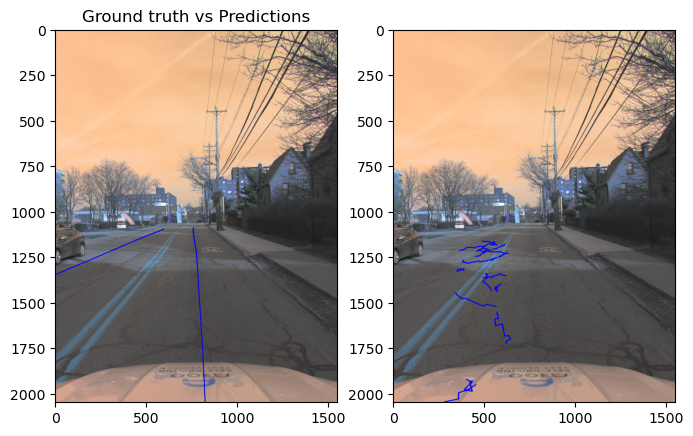

In [20]:
visualization(img_file, pts_2d_gt, pts_2d_preds)

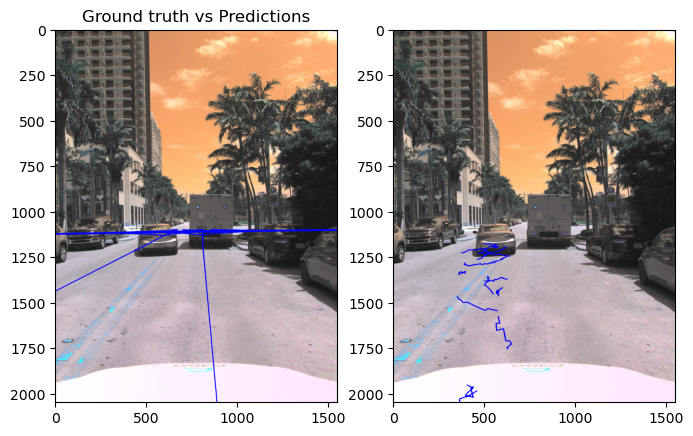

In [21]:
# Sample Visualization 2

img_file = f"./images/{val_dataset.annotations[1][0]}"
gt_points = val_dataset.annotations[1][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[1][0], extrinsic_list[1][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

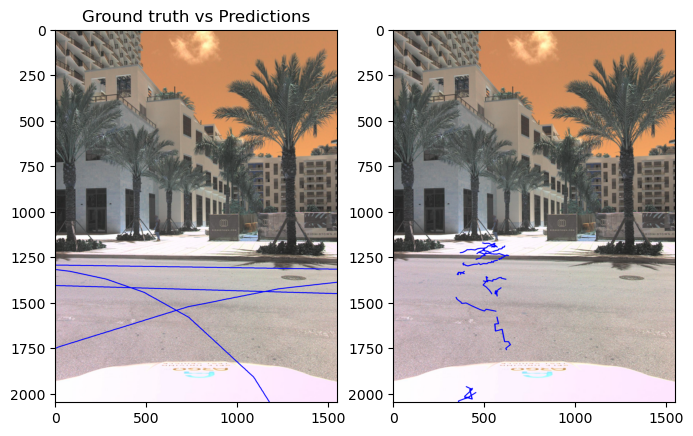

In [22]:
# Sample Visualization 3

img_file = f"./images/{val_dataset.annotations[2][0]}"
gt_points = val_dataset.annotations[2][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[2][0], extrinsic_list[2][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

#### RESNET 50 base model with Additional Layers

In [23]:
# Resnet 50 backbone with additional conv layers and linear to help learn complex features

class ResNet3DLaneDetection(nn.Module):
    def __init__(self, num_points, max_num_lane_lines):
        super(ResNet3DLaneDetection, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Remove the fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Add additional convolutional layers
        self.extra_conv = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        # Add a global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Add fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, max_num_lane_lines * num_points * 3)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.extra_conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x.view(x.size(0), max_num_lane_lines, num_points, 3)


In [24]:
# Load model for evaluation
num_points = 10
max_num_lane_lines = 61

model = ResNet3DLaneDetection(num_points=num_points, max_num_lane_lines=max_num_lane_lines)

weights = "./models/lane_detection_model_v2.pth"

predicted_points_3d_list, intrinsic_list, extrinsic_list = get_predictions(model, weights)

/var/folders/hq/dgkwpqzd10xgjv9hflydy7tm0000gn/T/ipykernel_88160/2824586381.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lane = torch.tensor(lane, dtype=torch.float)


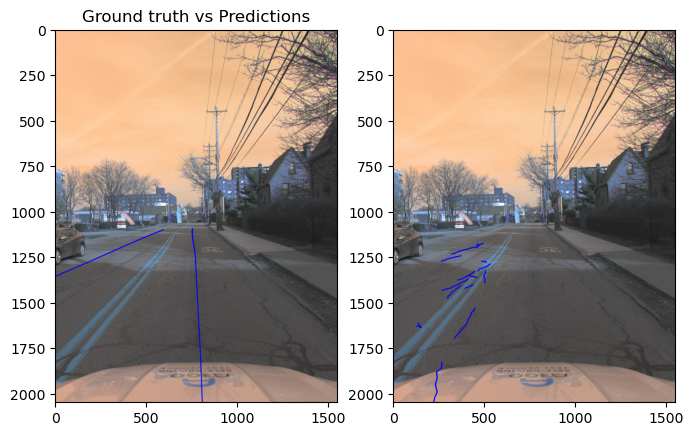

In [25]:
# Sample Visualization 1

img_file = f"./images/{val_dataset.annotations[0][0]}"
gt_points = val_dataset.annotations[0][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[0][0], extrinsic_list[0][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

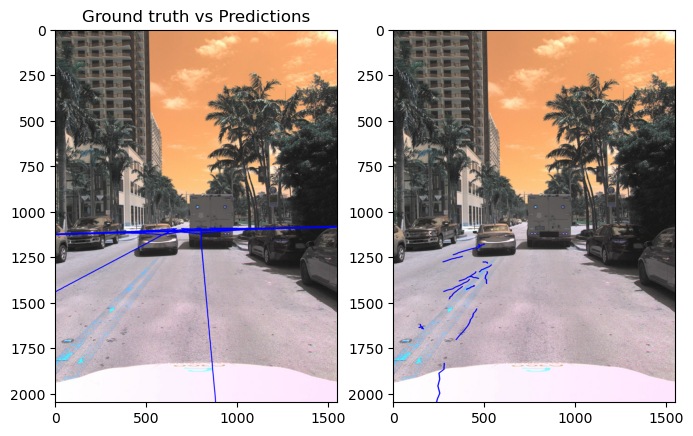

In [26]:
# Sample Visualization 2

img_file = f"./images/{val_dataset.annotations[1][0]}"
gt_points = val_dataset.annotations[1][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[1][0], extrinsic_list[1][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

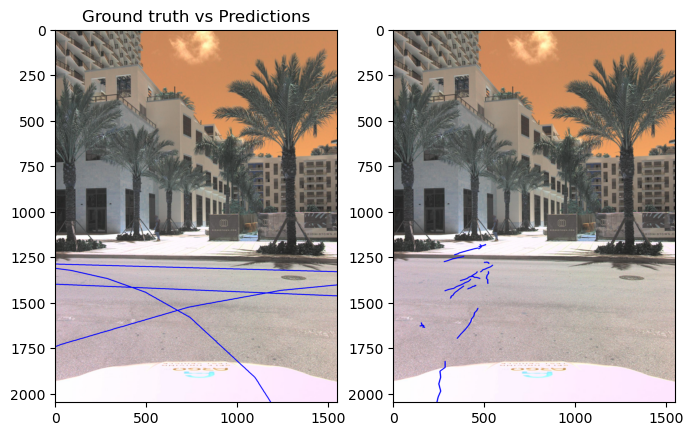

In [27]:
# Sample Visualization 3

img_file = f"./images/{val_dataset.annotations[2][0]}"
gt_points = val_dataset.annotations[2][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[2][0], extrinsic_list[2][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

## Lane Line Detection using Vision Transformer

We will use the pre-trained Vision Transformer and fine tuning it to predict 3d lane line points. 

In [28]:
class ViTLaneDetection(nn.Module):
    def __init__(self, num_points, max_num_lane_lines, hidden_dim=512, num_heads=8):
        super(ViTLaneDetection, self).__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit = ViTModel(config)
        
        # Additional layers
        self.attention = nn.MultiheadAttention(embed_dim=config.hidden_size, num_heads=num_heads)
        self.fc1 = nn.Linear(config.hidden_size, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, max_num_lane_lines * num_points * 3)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        x = outputs.last_hidden_state  
        
        # Transpose to match the expected input shape for nn.MultiheadAttention (L, N, E)
        x = x.transpose(0, 1)
        x, _ = self.attention(x, x, x)
        
        # Use the [CLS] token
        x = x[0]
        
        # Pass through additional layers
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        # Reshape to (batch_size, max_num_lane_lines, num_points, 3)
        return x.view(x.size(0), max_num_lane_lines, num_points, 3)  


In [29]:
# Load model 

# Load model for evaluation
num_points = 10
max_num_lane_lines = 61

model = ViTLaneDetection(num_points=num_points, max_num_lane_lines=max_num_lane_lines)

weights = "./models/vit_lane_detection_model_mlt_attn_v1.pth"

predicted_points_3d_list, intrinsic_list, extrinsic_list = get_predictions(model, weights)

/var/folders/hq/dgkwpqzd10xgjv9hflydy7tm0000gn/T/ipykernel_88160/2824586381.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lane = torch.tensor(lane, dtype=torch.float)


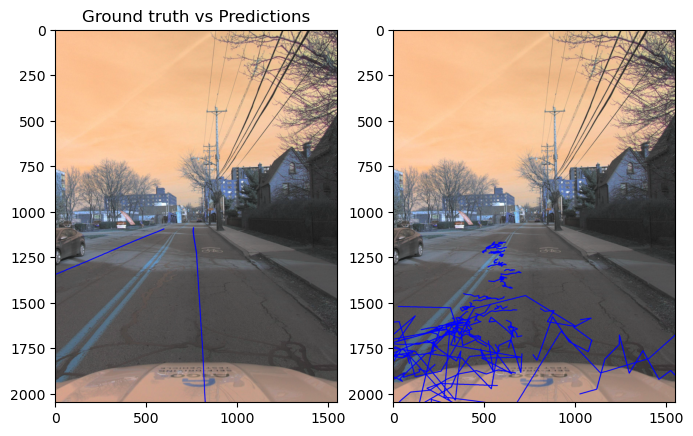

In [30]:
# Sample Visualization 1

img_file = f"./images/{val_dataset.annotations[0][0]}"
gt_points = val_dataset.annotations[0][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[0][0], extrinsic_list[0][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

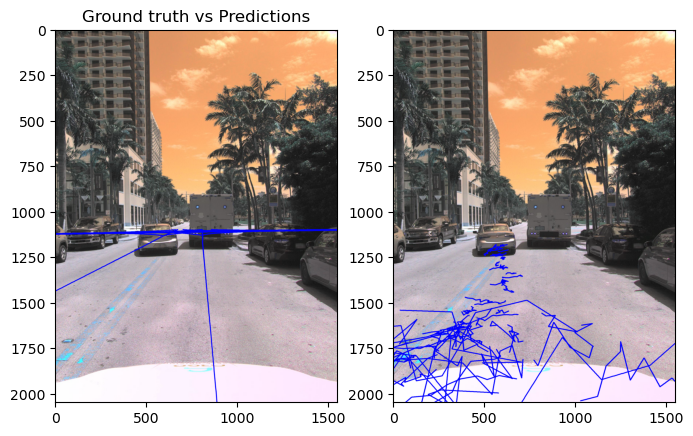

In [31]:
# Sample Visualization 2

img_file = f"./images/{val_dataset.annotations[1][0]}"
gt_points = val_dataset.annotations[1][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[1][0], extrinsic_list[1][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

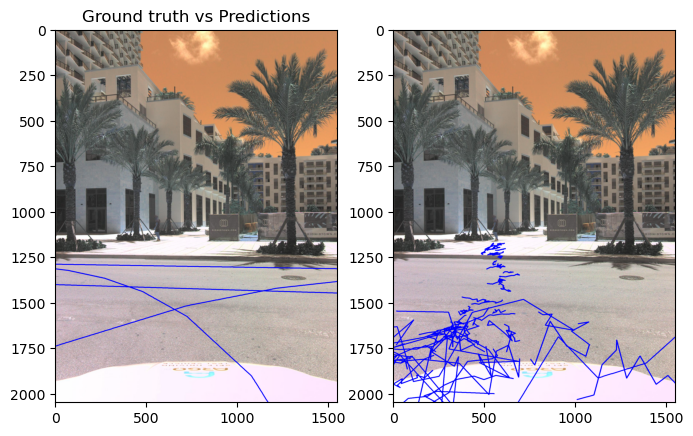

In [32]:
# Sample Visualization 3

img_file = f"./images/{val_dataset.annotations[2][0]}"
gt_points = val_dataset.annotations[2][3]

points_3d = flatten_points(predicted_points_3d_list)

pts_2d_gt, pts_2d_preds = project_3D_2D(gt_points, points_3d, intrinsic_list[2][0], extrinsic_list[2][0])

visualization(img_file, pts_2d_gt, pts_2d_preds)

## Summary

* The visualizations clearly show that adding more convolutional layers to the base ResNet model enhances the fine-tuning process, allowing it to better learn the curvature of lane lines

* The results from the fine-tuned Vision Transformer model indicate a need for improved architecture and training to more effectively learn the curvature of lane lines